## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5. Modeling 1 - RPI Prediction

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5. Modeling (1) RPI prediction based on stats

In [10]:
import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [2]:
%store -r y_RPI
%store -r X_famd

In [3]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [5]:
y = y_RPI
X = X_famd.copy()
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,4.088210,0.387175,0.445653,0.163744,-0.851128,-0.214929,0.035298,0.334836,-0.238593,0.132638,-0.096404,-0.230721,0.724759,0.239172,-0.196974,0.123700,-0.659215,0.179900,0.149158,-0.141219,0.007681,0.239291,0.107305,0.245343,-1.014234,-0.590747,-0.738947,1.852771,-0.265191,0.174415,-0.429634,0.164561,0.395233,-0.062863,-0.429432,0.033320,-0.627806,-0.459146,0.893360,-0.665163,-0.459985,0.193029,1.167426,-0.532660,0.290076,-0.015480,0.042561,0.014975,0.022471
1,3.039649,0.573932,1.019195,-0.008529,-0.105167,-0.278156,-0.578188,1.381380,0.647713,0.348277,0.486808,-1.041180,0.607301,0.458557,-0.665832,0.166477,0.448922,0.085372,0.095148,-0.387200,0.068609,-0.190076,-0.382729,0.054667,0.261591,-0.048113,0.250106,-0.285577,-0.010294,-0.068780,-0.059135,0.664097,0.022550,-0.298486,-0.370220,-0.302473,0.322416,-0.080986,0.403295,0.381319,-0.723193,-0.212759,0.612853,-0.224088,0.315445,0.238924,0.023582,0.023566,-0.026298
2,2.308711,1.463145,0.340674,-0.164757,0.032279,-0.304728,-0.623298,1.443160,0.583311,0.374074,0.512658,-1.057005,0.577237,0.498005,-0.651375,0.189152,0.472450,0.126613,0.092968,-0.322832,0.021193,-0.222821,-0.353709,0.040494,0.255637,-0.009808,0.255917,-0.263166,0.004152,-0.029132,-0.081225,0.576958,0.513122,-0.594303,-0.365217,0.032392,0.198868,-0.306602,0.109044,-0.225270,-0.517234,-0.165670,0.807288,-0.191574,0.007938,0.148736,0.113365,-0.006232,-0.033362
3,2.422937,0.126035,0.628305,-0.688452,0.025794,-0.133299,-0.491045,1.337943,0.587932,0.312107,0.565866,-1.047365,0.558485,0.426575,-0.714720,0.127740,0.482935,0.109800,0.076740,-0.317111,0.062534,-0.138181,-0.377141,0.077760,0.231932,-0.018397,0.233925,-0.298907,0.035898,-0.028339,-0.063785,0.500007,0.386299,0.082602,-0.647256,-0.021146,0.167409,-0.083012,0.534428,0.000765,0.412972,-0.011803,-0.041421,-0.221896,0.274458,-0.047145,-0.054609,-0.022842,-0.002856
4,2.996733,-0.096362,1.312312,0.329128,-0.102805,0.639735,-0.084065,-0.309899,0.577889,0.009138,0.448259,-0.027963,0.309472,0.844465,1.316197,-0.762520,0.088694,0.622191,-0.150506,0.283134,-0.122311,-0.119393,0.286827,-0.173641,-0.005989,0.102410,-0.012245,0.026272,-0.047858,0.031675,0.014787,0.061146,-0.255501,-0.575104,-0.108417,0.016573,0.075637,0.147530,0.558082,0.041496,-0.183988,0.152816,0.475336,-0.251809,-0.073757,-0.246787,0.035299,-0.019986,0.030788


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',nthread= -1,gpu_id=-1)

In [9]:
folds = 5
param_comb = 10

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=4
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10 candidates, totalling 50 fits

 Time taken: 0 hours 0 minutes and 43.34 seconds.


In [11]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd01.csv', index=False)


 All results:
{'mean_fit_time': array([2.2215682 , 1.13196931, 1.87483253, 4.200352  , 6.16516595,
       2.66683216, 5.37657599, 1.38813686, 2.74721584, 3.59944258]), 'std_fit_time': array([0.01506034, 0.0712224 , 0.10229993, 0.1730097 , 0.65216474,
       0.19570758, 0.16487878, 0.03938784, 0.09319721, 0.56879643]), 'mean_score_time': array([0.00678492, 0.00691381, 0.00579915, 0.00679526, 0.00680265,
       0.00570111, 0.00618429, 0.00513811, 0.00592222, 0.0053153 ]), 'std_score_time': array([0.0010869 , 0.00168105, 0.00079504, 0.00075283, 0.00051754,
       0.00056273, 0.00054658, 0.00079976, 0.00048855, 0.00141101]), 'param_subsample': masked_array(data=[0.6, 0.6, 0.6, 1.0, 0.8, 0.6, 0.8, 0.8, 0.6, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             mask=[False, False, False, False, False,



Best Train R_squared 5-fold search with 10 parameter combinations:
0.9515293092829084


Best Test R_squared 5-fold search with 10 parameter combinations:
0.8877878993586774


Best R_squared 5-fold search with 10 parameter combinations:
0.9389269535544268


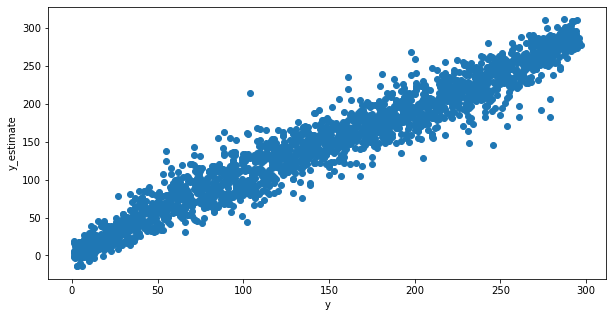

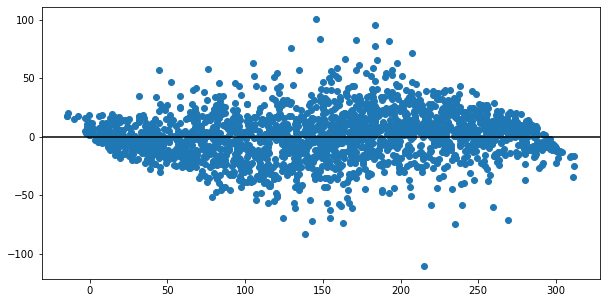

In [12]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))
print('\n\nBest R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X),y-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

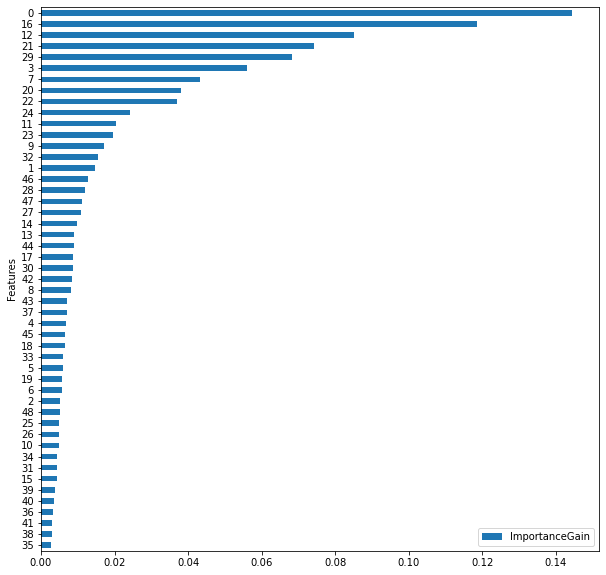

,Features,ImportanceGain,CummulativeGain
0,0,0.144443,0.144443
16,16,0.118516,0.262959
12,12,0.085060,0.348018
21,21,0.074256,0.422274
29,29,0.068262,0.490536
3,3,0.056045,0.546582
7,7,0.043219,0.589801
20,20,0.038130,0.627931
22,22,0.037017,0.664948
24,24,0.024165,0.689113


In [16]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1